
 Geospatial analysis of donations, food wastage, and hunger index across different regions in Africa. 


In [18]:
#libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
# Use a backend compatible with the current interactive framework
import seaborn as sns
import mplcursors
import numpy as np
%matplotlib widget
# %matplotlib inline

# Importing libraries for interactive plots
plt.ion()  


# Defining centroids for Africa sub-regions
region_centroids = {
    'North Africa': (30.0, 5.0),      
    'Central Africa': (0.0, 20.0),    
    'Southern Africa': (-25.0, 25.0), 
    'West Africa': (10.0, -5.0),      
    'East Africa': (0.0, 40.0)}


# Load data
donations_df = pd.read_csv("donations.csv")
hunger_df = pd.read_csv("hunger.csv")
food_wastage_df = pd.read_csv("food_wastage.csv")


# Cleaning the data
donations_df = donations_df.dropna()
food_wastage_df = food_wastage_df.dropna()
hunger_df = hunger_df.dropna()

# Printing cleaned DataFrames to check contents
print("Cleaned Donations DataFrame:\n", donations_df)
print("Cleaned Food Wastage DataFrame:\n", food_wastage_df)
print("Cleaned Hunger DataFrame:\n", hunger_df)



Cleaned Donations DataFrame:
               region  donation_amount donation_type        date
0       North Africa          6324.54          food  2025-01-01
2     Central Africa          5978.00          food  2025/03/01
4       North Africa           438.55          Food  03-25-2025
6        West Africa          2385.47       clothes  Feb 5 2025
7        West Africa          6815.00          food  01-02-2025
..               ...              ...           ...         ...
493      East Africa          5585.00       clothes  2025/03/01
494      East Africa          5931.00          food  Feb 5 2025
495   Central Africa          4950.36       Clothes  Feb 5 2025
496  Southern Africa          8552.00          food  03-25-2025
497      West Africa          2747.00       Clothes  03-25-2025

[218 rows x 4 columns]
Cleaned Food Wastage DataFrame:
               region  food_wastage
2        East Africa        2153.0
7    Southern Africa        3144.3
9        East Africa        2455.3
11   

In [19]:
# Merging the DataFrames
merged_df = pd.merge(donations_df, hunger_df, on='region')
merged_df = pd.merge(merged_df, food_wastage_df, on='region')
print("Merged DataFrame:\n", merged_df)



Merged DataFrame:
               region  donation_amount donation_type        date  hunger_index  \
0       North Africa          6324.54          food  2025-01-01          40.2   
1       North Africa          6324.54          food  2025-01-01          40.2   
2       North Africa          6324.54          food  2025-01-01          40.2   
3       North Africa          6324.54          food  2025-01-01          40.2   
4       North Africa          6324.54          food  2025-01-01          40.2   
...              ...              ...           ...         ...           ...   
470022   West Africa          2747.00       Clothes  03-25-2025          77.5   
470023   West Africa          2747.00       Clothes  03-25-2025          77.5   
470024   West Africa          2747.00       Clothes  03-25-2025          77.5   
470025   West Africa          2747.00       Clothes  03-25-2025          77.5   
470026   West Africa          2747.00       Clothes  03-25-2025          77.5   

        

In [20]:
# Drop of the population column and date columns
merged_df = merged_df.drop(['population', 'date'], axis=1)
print("Merged DataFrame after dropping columns:\n", merged_df.head())



Merged DataFrame after dropping columns:
          region  donation_amount donation_type  hunger_index  food_wastage
0  North Africa          6324.54          food          40.2        2513.0
1  North Africa          6324.54          food          40.2        3607.1
2  North Africa          6324.54          food          40.2        4987.1
3  North Africa          6324.54          food          40.2        1914.0
4  North Africa          6324.54          food          40.2        1490.2


In [21]:
# Adding coordinates to each DataFrame
if 'latitude' not in merged_df.columns or 'longitude' not in merged_df.columns:
    merged_df['latitude'] = merged_df['region'].map(lambda x:
                                                     region_centroids.get(x, (None, None))[0])
    merged_df['longitude'] = merged_df['region'].map(lambda x:
                                                      region_centroids.get(x, (None, None))[1])
    merged_df = merged_df.dropna(subset=['latitude', 'longitude'])

print("Merged DataFrame:\n", merged_df.head())




Merged DataFrame:
          region  donation_amount donation_type  hunger_index  food_wastage  \
0  North Africa          6324.54          food          40.2        2513.0   
1  North Africa          6324.54          food          40.2        3607.1   
2  North Africa          6324.54          food          40.2        4987.1   
3  North Africa          6324.54          food          40.2        1914.0   
4  North Africa          6324.54          food          40.2        1490.2   

   latitude  longitude  
0      30.0        5.0  
1      30.0        5.0  
2      30.0        5.0  
3      30.0        5.0  
4      30.0        5.0  


In [22]:
# Defining data_files using merged_df with different value columns
data_files = [
    ('Donations', 'donation_amount'),
    ('Food_Wastage', 'food_wastage'),
    ('Hunger', 'hunger_index')
]

# Creating dataframes dictionary from merged_df
dataframes = {f"{name.lower()}.csv": (merged_df, value_column) for name, value_column in data_files}

In [23]:
# Function to plot geospatial data
def plot_geospatial_seaborn(df, title, color, label, scale_factor, value_column,
                             min_size=50, max_size=500):
    lat = df['latitude'].values
    lon = df['longitude'].values
    try:
        values = df[value_column].values
    except KeyError:
        print(f"Error: Column '{value_column}' not found. Available columns:{df.columns.tolist()}")
        return
    
    if len(lat) == 0 or len(lon) == 0 or len(values) == 0:
        print(f"Skipping {title}: No data to plot.")
        return

    print(f"{title} - Data points to plot: {len(lat)}")

    # Creating figure and map
    plt.figure(figsize=(10, 6))
    m = Basemap(projection='merc', llcrnrlat=-35, urcrnrlat=40, llcrnrlon=-20,
                 urcrnrlon=55, resolution='c')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='lightgray', lake_color='white')
    m.drawmapboundary(fill_color='white')

    # Converting lat/lon to map coordinates
    x, y = m(lon, lat)

    # Printing coordinates and values
    print(f"{title} - x: {x[:5]}, y: {y[:5]}, values: {values[:5]}")  
   
    # Getting current axis
    ax = plt.gca()
    
    # Defining scatter for hover to work
    scatter = sns.scatterplot(x=x, y=y, size=values*scale_factor, sizes=(min_size, max_size),
                               color=color, alpha=0.6, legend=False, ax=ax, zorder=10)

    # Adding title and label
    plt.title(title, fontsize=12)
    plt.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=12,
              bbox=dict(facecolor='white', alpha=0.8))
   
    # Adding hover functionality
    print("Setting up hover functionality...")
    cursor = mplcursors.cursor(scatter, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        try:
            idx = sel.index
            region = df['region'].iloc[idx]
            value = df[value_column].iloc[idx]
            print(f"Hover triggered at index {idx}: Region={region}, Value={value}") 
            sel.annotation.set_text(f"Region: {region}\n{label}: {value:.2f}")
        except Exception as e:
            print(f"Error: {e}")

    # Connect the on_add function to the cursor
    cursor.connect("add", on_add)

    plt.show()
  


Regional Donations Geospatial Distribution  - Data points to plot: 470027
Regional Donations Geospatial Distribution  - x: [2779871.85711703 2779871.85711703 2779871.85711703 2779871.85711703
 2779871.85711703], y: [7658847.68851892 7658847.68851892 7658847.68851892 7658847.68851892
 7658847.68851892], values: [6324.54 6324.54 6324.54 6324.54 6324.54]
Setting up hover functionality...


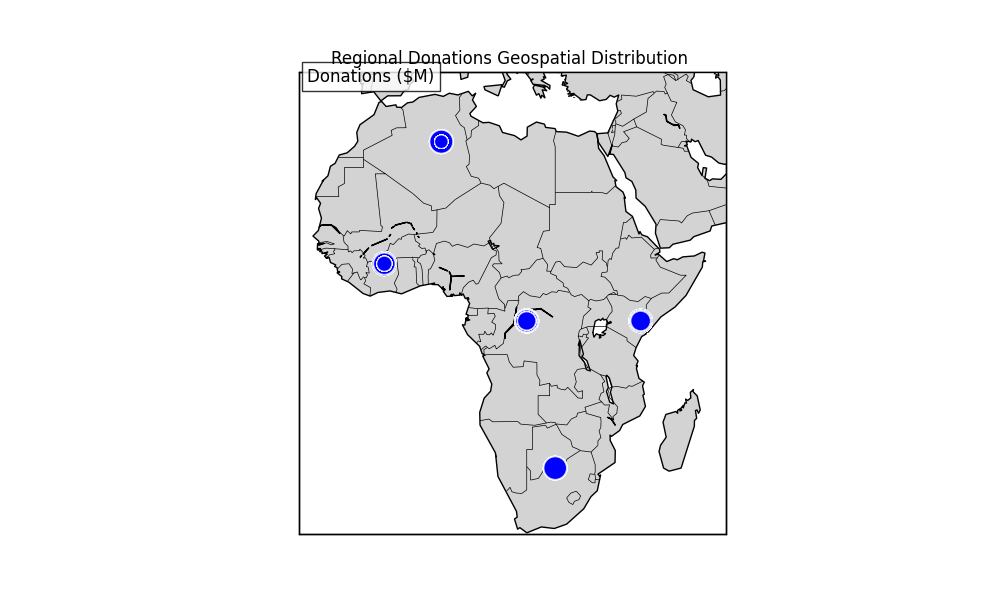

Regional Food wastage Geospatial Distribution  - Data points to plot: 470027


/var/folders/jb/v0nj2qy92rj18xgj5h98g2zm0000gn/T/ipykernel_4670/3320169132.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Regional Food wastage Geospatial Distribution  - x: [2779871.85711703 2779871.85711703 2779871.85711703 2779871.85711703
 2779871.85711703], y: [7658847.68851892 7658847.68851892 7658847.68851892 7658847.68851892
 7658847.68851892], values: [2513.  3607.1 4987.1 1914.  1490.2]
Setting up hover functionality...


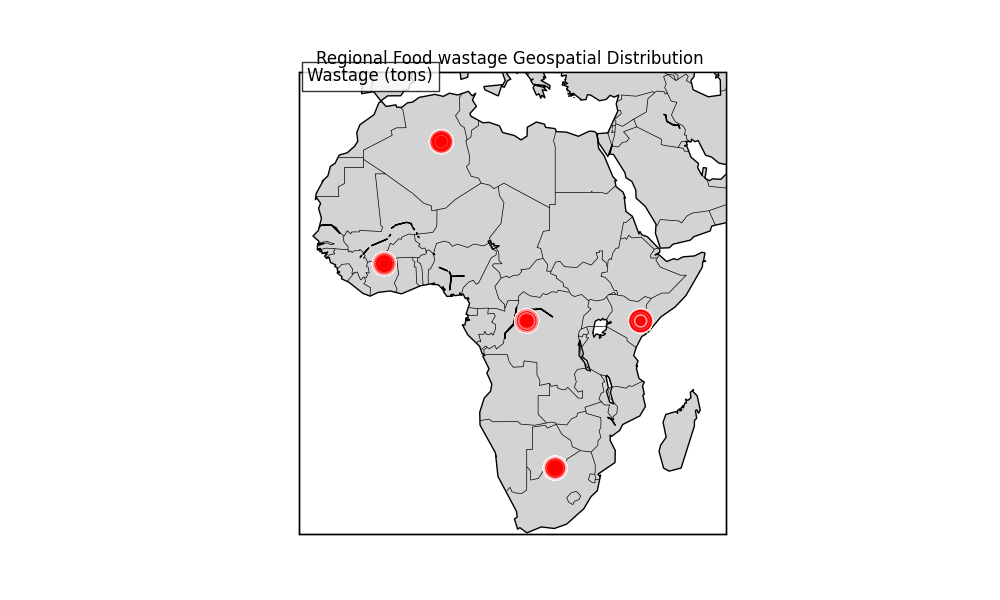

Regional Hunger Geospatial Distribution  - Data points to plot: 470027
Regional Hunger Geospatial Distribution  - x: [2779871.85711703 2779871.85711703 2779871.85711703 2779871.85711703
 2779871.85711703], y: [7658847.68851892 7658847.68851892 7658847.68851892 7658847.68851892
 7658847.68851892], values: [40.2 40.2 40.2 40.2 40.2]
Setting up hover functionality...


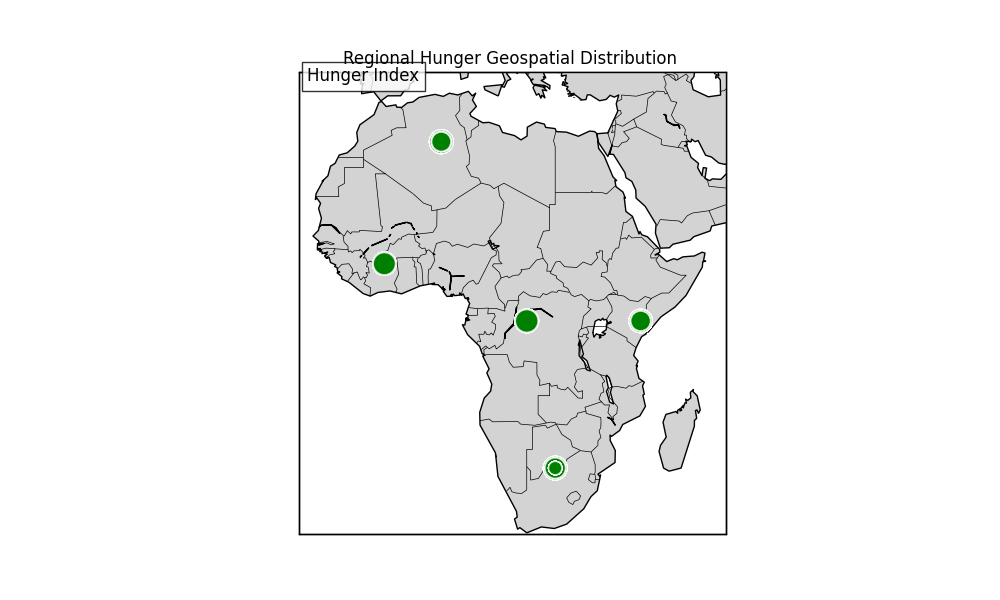

In [24]:
# Ploting each dataset using plot_geospatial_seaborn
for file_name, (df, value_column) in dataframes.items():
    title = f"Regional {file_name.split('.')[0].capitalize().replace('_', (' '))} Geospatial Distribution "
    color = {'donations.csv': 'blue', 'food_wastage.csv': 'red', 'hunger.csv': 'green'}[file_name]
    label = {'donations.csv': 'Donations ($M)', 'food_wastage.csv': 'Wastage (tons)',
              'hunger.csv': 'Hunger Index'}[file_name]
    scale_factor = {'donations.csv': 0.05, 'food_wastage.csv': 10, 'hunger.csv': 1000}[file_name]
    plot_geospatial_seaborn(df, title, color, label, scale_factor, value_column,
                             min_size=50, max_size=300)


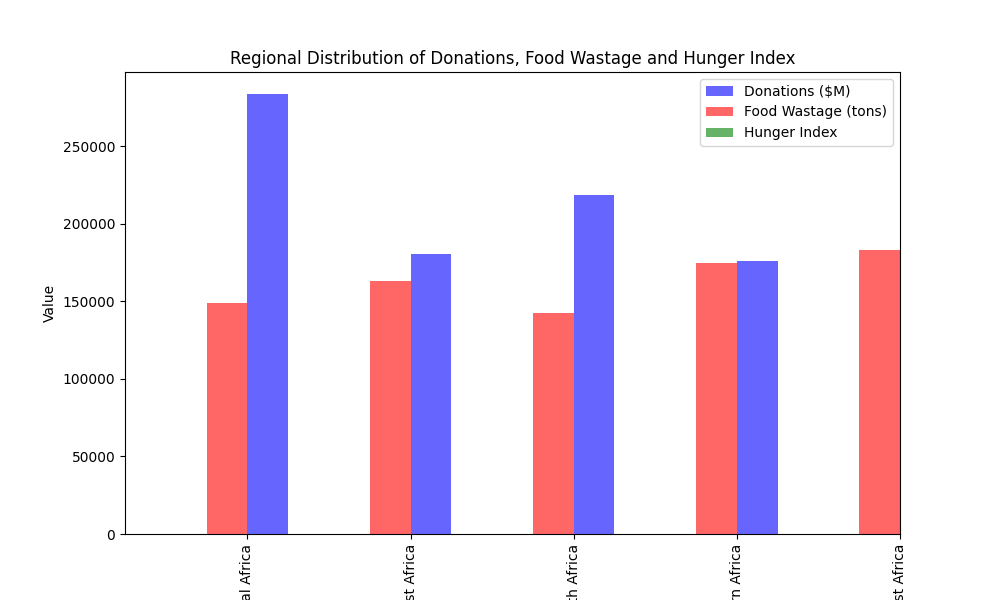

In [25]:
# Bar chart to visualise distribution by region
region_donations = donations_df.groupby('region')['donation_amount'].sum()
region_food_wastage = food_wastage_df.groupby('region')['food_wastage'].sum()
region_hunger = hunger_df.groupby('region')['hunger_index'].mean()

# Figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot bar chart for donations
region_donations.plot(kind='bar', color='blue', alpha=0.6, ax=ax, position=0, width=0.25)

# Plot bar chart for food wastage
region_food_wastage.plot(kind='bar', color='red', alpha=0.6, ax=ax, position=1, width=0.25)

# Plot bar chart for hunger index
region_hunger.plot(kind='bar', color='green', alpha=0.6, ax=ax, position=2, width=0.25)

# Add title and labels
plt.title("Regional Distribution of Donations, Food Wastage and Hunger Index", fontsize=12)
plt.ylabel("Value")
plt.xlabel("Region")
plt.legend(['Donations ($M)', 'Food Wastage (tons)', 'Hunger Index'])

# Show plot
plt.show()












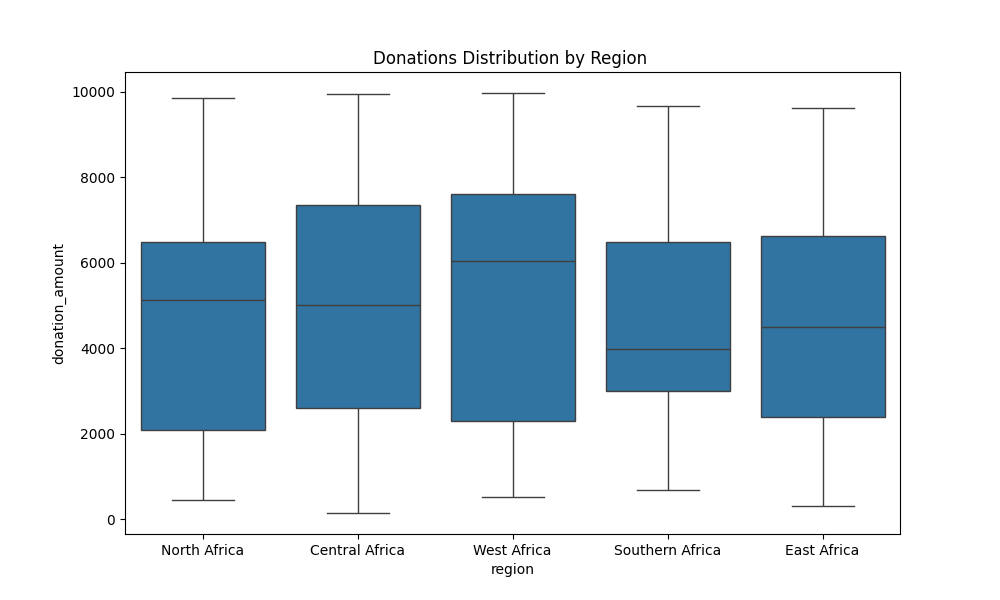

In [26]:
# Boxplot to visualise donations distribution by region
plt.figure(figsize=(10, 6))
sns.boxplot(data=donations_df, x='region', y='donation_amount')
plt.title("Donations Distribution by Region ")
plt.show()

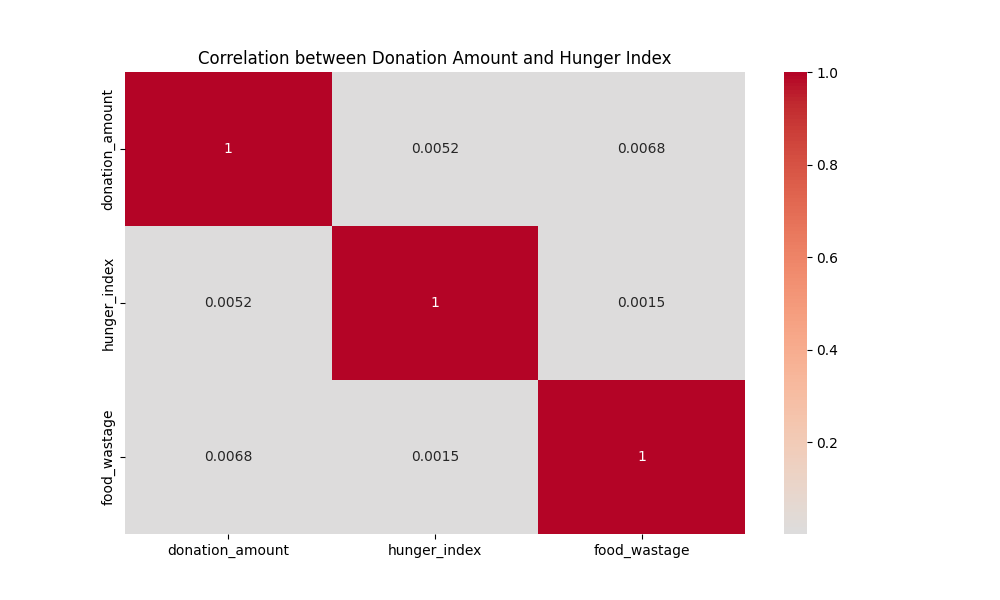

In [27]:
# Correlation matrix to visualise correlation between donation amount, hunger index, food wastage
plt.figure(figsize=(10, 6))
correlation_matrix = merged_df[['donation_amount', 'hunger_index', 'food_wastage']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between Donation Amount and Hunger Index")
plt.show()






